In [1]:
import torch
from transformers import CLIPProcessor, CLIPModel
from transformers import CLIPTextModelWithProjection, CLIPVisionModelWithProjection
from PIL import Image
from torch.nn.functional import cosine_similarity
import requests

In [2]:
CLIP_MODEL = "openai/clip-vit-base-patch32"

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = CLIPProcessor.from_pretrained(CLIP_MODEL)
model = CLIPModel.from_pretrained(CLIP_MODEL).to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [4]:
model.eval()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

Part 1

Pre-encoding candidate text sets with HF CLIP...


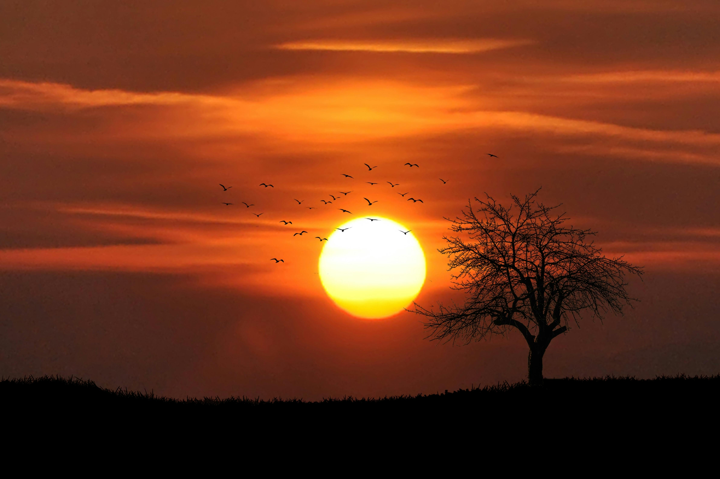


=== Image 1 ===
URL: https://images.pexels.com/photos/36744/agriculture-arable-clouds-countryside.jpg
(a) single word           : sunset               | cos = 0.2658
(b) 'A photo of a W'      : A photo of a sunset  | cos = 0.2787
(c) arbitrary caption     : An image of an orange sunset with a silhouetted tree with a flock of birds. | cos = 0.3610


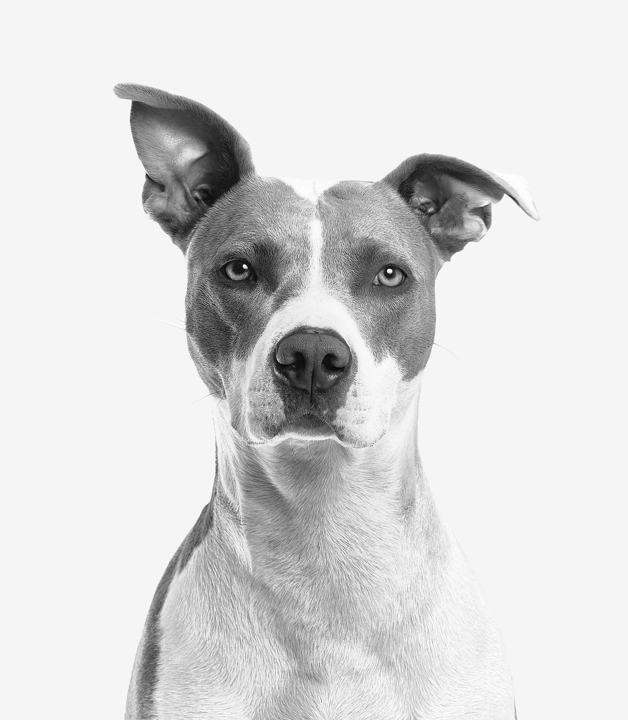


=== Image 2 ===
URL: https://images.pexels.com/photos/825947/pexels-photo-825947.jpeg
(a) single word           : dog                  | cos = 0.2825
(b) 'A photo of a W'      : A photo of a dog     | cos = 0.2922
(c) arbitrary caption     : An image of a studio portrait of a dog on a white background high key lighting. | cos = 0.3486


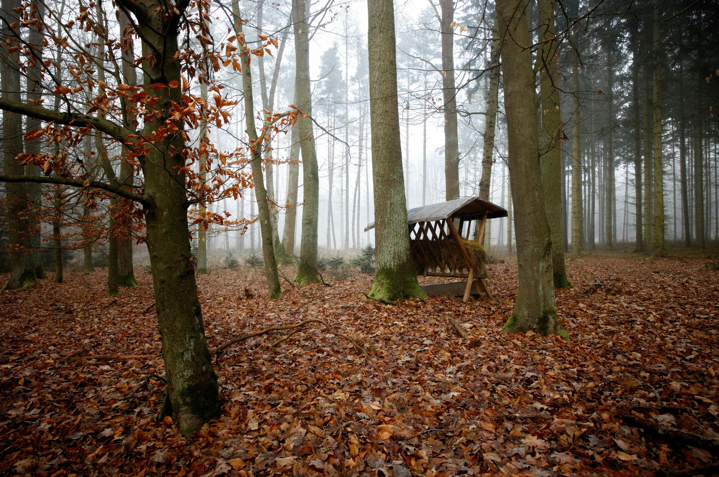


=== Image 3 ===
URL: https://images.pexels.com/photos/34044163/pexels-photo-34044163.jpeg
(a) single word           : mist                 | cos = 0.2688
(b) 'A photo of a W'      : A photo of a foggy   | cos = 0.2956
(c) arbitrary caption     : A photograph of a foggy forest with two unmade beds in autumn. | cos = 0.3659


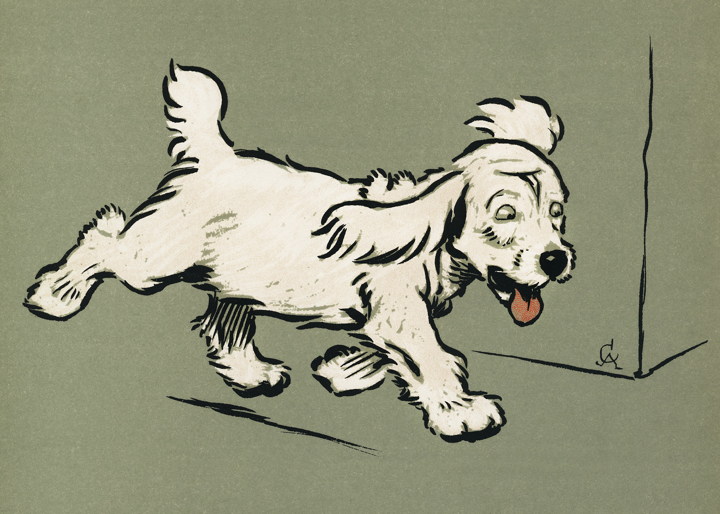


=== Image 4 ===
URL: https://live.staticflickr.com/840/43380549381_004601c7ac_h.jpg
(a) single word           : dog                  | cos = 0.2535
(b) 'A photo of a W'      : A photo of a cartoon | cos = 0.2675
(c) arbitrary caption     : A photograph of a small white dog cartoon style. | cos = 0.3458


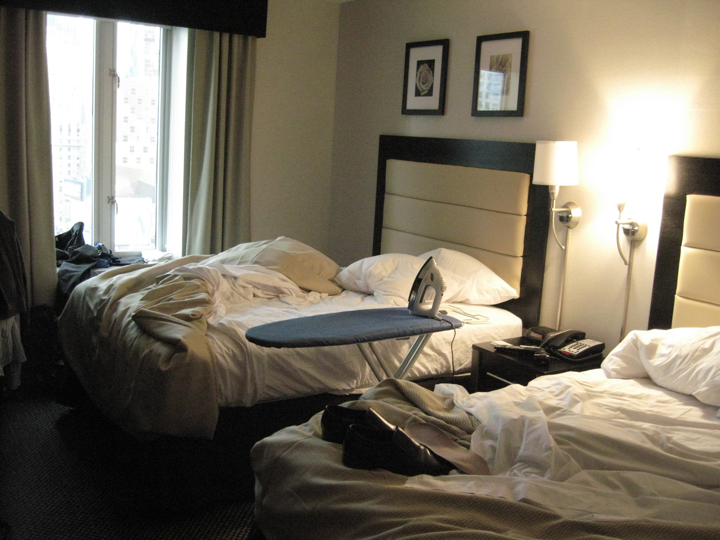


=== Image 5 ===
URL: https://live.staticflickr.com/2404/2020522557_d1aa0a1066_k.jpg
(a) single word           : beds                 | cos = 0.2826
(b) 'A photo of a W'      : A photo of a bedroom | cos = 0.2968
(c) arbitrary caption     : A photograph of a hotel room with two unmade beds facing the camera. | cos = 0.3347

Saved CSV:  outputs/part1_clip_results.csv
Saved JSON: outputs/part1_clip_results.json


In [5]:
import os, io, json, csv, itertools, random, requests
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from IPython.display import display
from google.colab import files


try:
    _ = processor, model, device
except NameError:
    raise RuntimeError("Please run your first 3 cells to load HF CLIP (processor/model/device) before Part 1.")

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

IMAGE_URLS = [
    "https://images.pexels.com/photos/36744/agriculture-arable-clouds-countryside.jpg",
    "https://images.pexels.com/photos/825947/pexels-photo-825947.jpeg",
    "https://images.pexels.com/photos/34044163/pexels-photo-34044163.jpeg",
    "https://live.staticflickr.com/840/43380549381_004601c7ac_h.jpg",
    "https://live.staticflickr.com/2404/2020522557_d1aa0a1066_k.jpg",
]

SIMPLE_WORDS = [
  # scenes
  "sunset","sunrise","forest","woods","park","field","meadow","beach","mountain","city",
  # animals
  "dog","puppy","cat","bird","sheep","cow","horse",
  # objects
  "bedroom","hotel","room","beds","iron","ironing","lamp","chair",
  # styles
  "illustration","drawing","painting","cartoon","sketch",
  # weather
  "fog","foggy","mist","clouds","overcast","storm","rain",
  # generic
  "tree","trees","sky","sun","road","path","house"
]
SUBJECTS = [
  "a dog","a puppy","a small white dog","a hotel room","a bedroom","a forest","a foggy forest",
  "a sunset","an orange sunset","a studio portrait of a dog","a cartoon dog","a drawing of a dog"
]
ATTRIBUTES = [
  "on a white background","with two unmade beds","with an ironing board","with a silhouetted tree",
  "with a flock of birds","with brown leaves","in autumn","in the fog","facing the camera",
  "high key lighting","cartoon style","line drawing"
]
LEADS = ["A photo of","A picture of","A photograph of","An image of"]

SINGLE_WORDS = sorted({w for w in SIMPLE_WORDS if w.strip() and " " not in w})

def build_structured_texts(words):
  # Create "A photo of a W" format as required
    return [f"A photo of a {w}" for w in words]

def build_arbitrary_texts(subjects, attributes, leads, max_attr=2, cap=4000):
   # Generate creative captions by combining elements
    texts = set()
   # Simple combinations: lead + subject
    for subj in subjects:
        for lead in leads:
            texts.add(f"{lead} {subj}.")
   # More detailed: lead + subject + attributes
    for subj in subjects:
        for k in range(1, max_attr+1):
            for attrs in itertools.combinations(attributes, k):
                for lead in leads:
                    texts.add(f"{lead} {subj} " + " ".join(attrs) + ".")
    out = sorted(texts, key=len)[:cap]
    return out

STRUCTURED_TEXTS = build_structured_texts(SINGLE_WORDS)
ARBITRARY_TEXTS  = build_arbitrary_texts(SUBJECTS, ATTRIBUTES, LEADS, max_attr=2, cap=4000)

def load_image_from_url(url: str) -> Image.Image:
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    return Image.open(io.BytesIO(r.content)).convert("RGB")

@torch.no_grad()
def encode_image_hf(img: Image.Image) -> torch.Tensor:
   # Process image through CLIP and normalize features
    inputs = processor(images=img, return_tensors="pt").to(device)
    feats  = model.get_image_features(**inputs)
    return F.normalize(feats, p=2, dim=-1).cpu()

@torch.no_grad()
def encode_texts_hf(texts, batch_size=128) -> torch.Tensor:
   # Process text in batches for efficiency
    all_feats = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = processor(text=batch, padding=True, truncation=True, return_tensors="pt").to(device)
        feats  = model.get_text_features(**inputs)
        feats  = F.normalize(feats, p=2, dim=-1).cpu()
        all_feats.append(feats)
    return torch.cat(all_feats, dim=0)

def cosine_row(img_feat, txt_feats):
    return (img_feat @ txt_feats.T).squeeze(0).numpy()

def top1(img_feat, texts, feats):
    s = cosine_row(img_feat, feats)
    j = int(np.argmax(s))
    return texts[j], float(s[j])

print("Pre-encoding candidate text sets with HF CLIP...")
single_feats = encode_texts_hf(SINGLE_WORDS)
struct_feats = encode_texts_hf(STRUCTURED_TEXTS)
arb_feats    = encode_texts_hf(ARBITRARY_TEXTS)

rows = []
for i, url in enumerate(IMAGE_URLS, 1):
    try:
        img = load_image_from_url(url)
    except Exception as e:
        print(f"[Image {i}] Could not load: {e}")
        continue

    w, h = img.size
    scale = 720 / max(w, h)
    display(img.resize((int(w*scale), int(h*scale))) if scale < 1 else img)

    img_feat = encode_image_hf(img)

    # (a) best single word
    best_w, sc_w = top1(img_feat, SINGLE_WORDS, single_feats)
    # (b) best "A photo of a W"
    best_struct, sc_struct = top1(img_feat, STRUCTURED_TEXTS, struct_feats)
    # (c) best arbitrary caption
    best_arb, sc_arb = top1(img_feat, ARBITRARY_TEXTS, arb_feats)

    print(f"\n=== Image {i} ===")
    print(f"URL: {url}")
    print(f"(a) single word           : {best_w:<20s} | cos = {sc_w:.4f}")
    print(f"(b) 'A photo of a W'      : {best_struct:<20s} | cos = {sc_struct:.4f}")
    print(f"(c) arbitrary caption     : {best_arb} | cos = {sc_arb:.4f}")

    rows.append({
        "image_index": i,
        "image_url": url,
        "best_single_word": best_w,
        "cosine_single_word": round(sc_w,4),
        "best_structured_caption": best_struct,
        "cosine_structured": round(sc_struct,4),
        "best_arbitrary_caption": best_arb,
        "cosine_arbitrary": round(sc_arb,4),
    })

os.makedirs("outputs", exist_ok=True)
csv_path  = "outputs/part1_clip_results.csv"
json_path = "outputs/part1_clip_results.json"

with open(csv_path, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
    w.writeheader(); w.writerows(rows)

with open(json_path, "w", encoding="utf-8") as f:
    json.dump(rows, f, indent=2)

print(f"\nSaved CSV:  {csv_path}")
print(f"Saved JSON: {json_path}")


Part 2

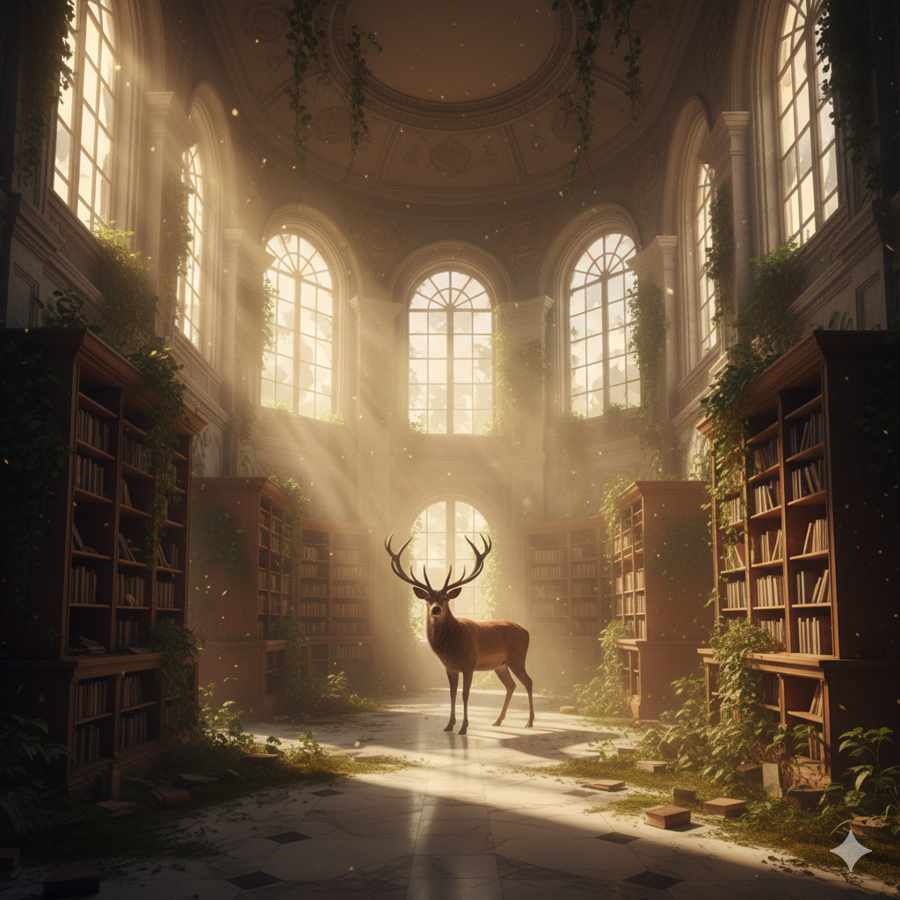


BEST CAPTION:
  a stag standing in a sunlit, overgrown library  |  cos = 0.4243


caption  cosine
0      a stag standing in a sunlit, overgrown library  0.4243
1           a stag in a dusty library with light rays  0.4194
2             a deer with antlers in a sunlit library  0.4155
3   a stag lit by golden sunbeams in a library fil...  0.4116
4   a deer in a grand library with sunlight stream...  0.4045
5                  a deer in a cathedral-like library  0.3987
6                    a majestic stag inside a library  0.3870
7                     a stag in a grand hall of books  0.3866
8   a stag in an old library with vines and booksh...  0.3820
9                                 a stag in a library  0.3794
10                                a deer in a library  0.3759
11          a deer standing in an ivy-covered library  0.3675
12                                   a sunlit library  0.3257
13                                a deer with antlers  0.2688

Saved: outputs/part2_best_caption_results.csv


In [6]:
import os, io, numpy as np, pandas as pd, torch, torch.nn.functional as F
from PIL import Image
from IPython.display import display, HTML
from google.colab import files

try:
    _ = processor, model, device
except NameError:
    raise RuntimeError("Please run your first 3 cells to load HF CLIP (processor/model/device) before Part 2.")

IMAGE_SOURCE = "mygeneratedimage.png"
TOP_K = 15
CSV_OUT = "outputs/part2_best_caption_results.csv"

if not os.path.exists(IMAGE_SOURCE):
    try:
        print("Local file not found. Please select your image to upload...")
        uploaded = files.upload()
        if uploaded:
            IMAGE_SOURCE = list(uploaded.keys())[0]
            print("Uploaded:", IMAGE_SOURCE)
    except Exception:
        raise FileNotFoundError(f"File '{IMAGE_SOURCE}' not found. Upload or set a valid path.")

img = Image.open(IMAGE_SOURCE).convert("RGB")

w, h = img.size
scale = 900 / max(w, h)
img_disp = img.resize((int(w*scale), int(h*scale))) if scale < 1 else img
display(HTML("<h3>Part 2 — One Image: Best Caption Search (HF CLIP)</h3>"))
display(img_disp)

CANDIDATE_CAPTIONS = [
    "a stag standing in a sunlit, overgrown library",
    "a deer with antlers in a sunlit library",
    "a stag in an old library with vines and bookshelves",
    "a deer in a grand library with sunlight streaming through windows",
    "a stag lit by golden sunbeams in a library filled with books",
    "a deer standing in an ivy-covered library",
    "a stag in a dusty library with light rays",
    "a majestic stag inside a library",
    "a deer in a cathedral-like library",
    "a stag in a grand hall of books",
    "a deer in a library",
    "a stag in a library",
    "a deer with antlers",
    "a sunlit library",
]

@torch.no_grad()
def encode_image_hf(img: Image.Image) -> torch.Tensor:
    inputs = processor(images=img, return_tensors="pt").to(device)
    feats  = model.get_image_features(**inputs)
    return F.normalize(feats, p=2, dim=-1).cpu()

@torch.no_grad()
def encode_texts_hf(texts) -> torch.Tensor:
    inputs = processor(text=texts, padding=True, truncation=True, return_tensors="pt").to(device)
    feats  = model.get_text_features(**inputs)
    return F.normalize(feats, p=2, dim=-1).cpu()

img_feat  = encode_image_hf(img)
text_feat = encode_texts_hf(CANDIDATE_CAPTIONS)

scores = (img_feat @ text_feat.T).squeeze(0).numpy()
order  = np.argsort(-scores)
best_idx = int(order[0])

best_caption = CANDIDATE_CAPTIONS[best_idx]
best_score   = float(scores[best_idx])

print("\nBEST CAPTION:")
print(f"  {best_caption}  |  cos = {best_score:.4f}")

topN = min(TOP_K, len(CANDIDATE_CAPTIONS))
df = pd.DataFrame({
    "caption": [CANDIDATE_CAPTIONS[i] for i in order[:topN]],
    "cosine":  [round(float(scores[i]), 4) for i in order[:topN]]
})
display(HTML("<h4>Top results</h4>"))
display(df)

os.makedirs("outputs", exist_ok=True)
df.to_csv(CSV_OUT, index=False)
print(f"Saved: {CSV_OUT}")

